### Datasets de Conversaciones del Bot y del CAD del 02-09-2024

#### Levanta ambos datasets y saca un informe descriptivo 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import string
from unicodedata import normalize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import json
import requests
import re
import time
import random
%matplotlib inline

#### Importar Datasets

In [3]:
#importo datasets
df_bot = pd.read_csv('data/bot.csv')
df_cad = pd.read_csv('data/cad.csv')

In [4]:
df_bot.head()

,conversacion_id,interaccion_nu,actor_tx,mensaje_tx
0,0010765e-ec36-412e-8cf3-c23c9ad32a56,1.0,USUARIO,Necesito ayuda
1,0010765e-ec36-412e-8cf3-c23c9ad32a56,2.0,BOT,Hola CLARISA ADRIANA ¿cómo estás? Acá Bot. |...
2,0010765e-ec36-412e-8cf3-c23c9ad32a56,3.0,USUARIO,Saldo de la deuda de visa y Master q di de baja
3,0010765e-ec36-412e-8cf3-c23c9ad32a56,4.0,BOT,Podemos hablar de muchas cosas sobre tarjetas....
4,0010765e-ec36-412e-8cf3-c23c9ad32a56,5.0,USUARIO,Resumen de otras tarjetas


In [5]:
df_cad.head()

,caso_id,mensaje_id,indice_cd,fecha_ts,cuerpo_mensaje_tx,actor,conversacion_id
0,13467703,69222608,2,2024-09-02 16:59:09,42307388 - #CLIENTE VALIDADO#,Cliente,2be02be1-d520-4bbd-ba49-a303cd4603a4
1,13467703,69222676,3,2024-09-02 16:59:36,Dale,Cliente,2be02be1-d520-4bbd-ba49-a303cd4603a4
2,13467703,69223054,4,2024-09-02 17:02:25,Hola Cristian. ¿Cómo estás? Mi nombre es Milen...,CAD,2be02be1-d520-4bbd-ba49-a303cd4603a4
3,13467703,69223057,5,2024-09-02 17:02:25,Veo que tenés inconvenientes con tus claves de...,CAD,2be02be1-d520-4bbd-ba49-a303cd4603a4
4,13467703,69223113,6,2024-09-02 17:02:55,Hola Milena,Cliente,2be02be1-d520-4bbd-ba49-a303cd4603a4


In [6]:
cant_convers_bot = df_bot['conversacion_id'].nunique()
cant_convers_cad_bot = df_cad['conversacion_id'].nunique()
cant_convers_cad = df_cad['caso_id'].nunique()

In [7]:
# Filtrar los registros que contengan la frase "responder por acá"
filtro = df_bot['mensaje_tx'].str.contains('responder por acá', case=False, na=False)
# Eliminar duplicados basados en la columna 'id'
df_bot_derivada_cad = df_bot[filtro].drop_duplicates(subset='conversacion_id')
# Obtener la cantidad de registros únicos por 'id' que contienen la frase
cant_bot_derivadas_cad = df_bot_derivada_cad.shape[0]

In [8]:
# Realizar el join entre los DataFrames basado 'conversacion_id'
df_join = pd.merge(df_bot, df_cad, left_on='conversacion_id', right_on='conversacion_id', how='inner')
# Obtener la cantidad de registros únicos que CAD recibió de Bot
cant_cad_recibidas_bot = df_join['conversacion_id'].nunique()

In [9]:
# Cantidad de conversaciones vacías
cant_cad_vacias = len(df_cad[df_cad['cuerpo_mensaje_tx']=='--Vacío--'])

In [10]:
# Convertir la columna 'fecha_ts' a datetime
df_cad['fecha_ts'] = pd.to_datetime(df_cad['fecha_ts'])
# Agrupar por 'conversacion_id' y calcular la diferencia de tiempo entre el primer y el último mensaje
df_demoras = df_cad.groupby('conversacion_id').agg(
    inicio_conversacion=('fecha_ts', 'min'),  # Obtener la fecha más antigua
    fin_conversacion=('fecha_ts', 'max')      # Obtener la fecha más reciente
)
# Calcular la demora de cada conversación
df_demoras['demora'] = (df_demoras['fin_conversacion'] - df_demoras['inicio_conversacion']).dt.total_seconds() / 60  # En minutos

In [11]:
# Eliminar outliers (conversaciones vacías (tiempo 0) y mayores de 200 minutos
df_demoras = df_demoras[(df_demoras['demora']>0) & (df_demoras['demora']<=200)]

In [12]:
# Obtener la demora promedio de todas las conversaciones
demora_promedio = df_demoras['demora'].mean()

#### Cantidades

In [13]:
print("Cantidad de conversaciones Bot:", cant_convers_bot)
print("Cantidad de conversaciones CAD:", cant_convers_cad)
#print("Cantidad de conversaciones que CAD recibió de Bot:", cant_convers_cad_bot)
print("Cantidad de conversaciones de Bot derivadas a CAD:", cant_bot_derivadas_cad)
print("Cantidad de conversaciones que CAD recibió de Bot:", cant_cad_recibidas_bot)
print("Cantidad de conversaciones de CAD vacías:", cant_cad_vacias)
print("Cantidad de conversaciones de CAD a procesar (sin outliers):", len(df_demoras))
print("Demora promedio de las conversaciones (en minutos): ", round(demora_promedio,1))

Cantidad de conversaciones Bot: 7097
Cantidad de conversaciones CAD: 8909
Cantidad de conversaciones de Bot derivadas a CAD: 6897
Cantidad de conversaciones que CAD recibió de Bot: 6898
Cantidad de conversaciones de CAD vacías: 37
Cantidad de conversaciones de CAD a procesar (sin outliers): 6838
Demora promedio de las conversaciones (en minutos):  41.1


In [14]:
# Correr la notebook hasta acá

### Nube Palabras ###

In [15]:
# '' default (ej: pagó), 's' stemmization (ej: pag_), 'l' lemmatization (ej: pagar)
forma_tokenizar = '' 
# lista custom stopwords
#con_stopwords = True

In [16]:
import nltk
import re

# lista de nuevas stopwords para agregar a las default
lista_stopwords = ["Bot","hola","eh","Quiero","quiero","Necesito","necesito","con","a","del","de","q","que","a","eh","mirá","mira","dale","quiero","necesito","si","sí","para","ya","yo"]  #para agregar stopwords

# separador de columnas
SEPARADOR = ","
# NUBE
NUBE_MAX_FUENTE=60
NUBE_MAX_PALABRAS=50

# limpiar puntuaciones y separar por tokens.
punctuation = string.punctuation + "«»""''…—"
stopwords = pd.read_csv(
    'https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt'
).values
stopwords = stopwords.flatten().tolist()
stopwords.extend(lista_stopwords)
#stopwords.remove("puedo") #para remover stopwords

In [17]:
def simple_tokenizer_NEW2(doc, lower=False):
    #doc = normalize(doc)
    if lower:
        tokenized_doc = doc.translate(str.maketrans(
            '', '', punctuation)).lower().split()
    tokenized_doc = str(doc).translate(str.maketrans('', '', punctuation)).split()
    tokenized_doc = [
        token for token in tokenized_doc if token.lower() not in stopwords
    ]
    return tokenized_doc


def normalize(s): #Vuela acentos
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def simple_tokenizer(doc,lem=None):
    doc = normalize(doc) #se pasa el texto a la función normalize
    tokenized_doc = ["" if t.isdigit() else t for t in doc.split()]  # se remueven los números
    tokenized_doc = [
        token.lower() for token in tokenized_doc if token.lower() not in stopwords and token != ""
    ] #se sacan las stopwords y ademas los tokens que quedan como "" ya que son números
    return tokenized_doc

def ngramas(df,gramas,columna=None,valor=None):
    df[f'{gramas}_gramas'] = df.apply(lambda row: list(nltk.ngrams(row, gramas)))
    lista = []
    def desarmar(lista_):
        for conjuntos in set(lista_):
            lista.append(conjuntos)
    if columna != None:
        df[df[columna]==valor][f'{gramas}_gramas'].apply(lambda x: desarmar(x))
    else:
        df[f'{gramas}_gramas'].apply(lambda x: desarmar(x))
    frequence = nltk.FreqDist(lista)
    sort = sorted(frequence.items(), key=operator.itemgetter(1), reverse=True)
    return sort


def nube_palabras(y):
    combined_text = ' '.join(y.sum())
    wordcloud = (
        WordCloud(max_font_size=NUBE_MAX_FUENTE, 
                  max_words=NUBE_MAX_PALABRAS,       
                  background_color="white",
                  collocations=False,
                  )
        .generate(combined_text)
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    #plt.title(title)
    plt.axis("off")
    plt.show()
    
#######################
# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
#STOPWORDS = set(stopwords.words('spanish'))
STOPWORDS = set(stopwords) # convierte una lista en dictionary de ['hola','a'] a {'hola','a'}
#if con_stopwords:
    #dict_stopwords = set(stopwords) # convierte una lista en dictionary de ['hola','a'] a {'hola','a'}
    #STOPWORDS.update(dict_stopwords) # extension stopwords para agregar
    #for i in stopwords_quitar:
    #    STOPWORDS.discard(i)  # para quitar

# función traída de otra notebook porque stemmer no convence
def simple_tokenizer(doc,stemm=False, lem=False):
    doc = normalize(doc) #se pasa el texto a la función normalize
    tokenized_doc = ["" if t.isdigit() else t for t in doc.split()]  # se remueven los números
    tokenized_doc = [
        #token.lower() for token in tokenized_doc if token.lower() not in stopwords and token != ""
        token.lower() for token in tokenized_doc if token.lower() not in STOPWORDS and token != ""
    ] #se sacan las stopwords y ademas los tokens que quedan como "" ya que son números
    if stemm:
        tokenized_doc = [stemmer.stem(str(token)) for token in tokenized_doc] #sólo el stemming de los tokens
    if lem: #lemmatization
        tokenized_doc = " ".join(tokenized_doc)
        tokenized_doc = [x.lemma_ for x in nlp(tokenized_doc)]
    return tokenized_doc


def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    text = str(text)
    # lowercase text
    text = text.lower() 
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    # Remove the XXXX values
    text = text.replace('x', '') 
    # Remove white space
    text = REMOVE_NUM.sub('', text)
    #  delete symbols which are in BAD_SYMBOLS_RE from text
    #text = BAD_SYMBOLS_RE.sub('', text) 
    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))
    # Stemming the words
    #text = ' '.join([stemmer.stem(word) for word in text.split()])
    # Stemming the words
    if forma_tokenizar == 's':
        text = ' '.join([stemmer.stem(str(word)) for word in text.split()])
    elif forma_tokenizar == 'l': #lemmatization
        text = ' '.join(x.lemma_ for x in nlp(text))
    return text

# sinónimos
def synonym_tokenizer(text):
    words = text.split()
    tokens = [sinonimos.get(word, word) for word in words]
    return tokens

In [18]:
## reemplaza textos determinados en la conversación
#import pandas as pd
#import re

# Función para reemplazar las frases específicas por un vacío
def reemplazar_textos(texto):
    # Lista de textos a reemplazar
    texto_basura = ["¡Hola!"
,"¡Hola "
,"Hola."
,"Hola "
,"hola "
,"Bot."
,"Bot!"
,"Bot "
,"Buenas tardes "
,"vengo de la App para hacer una consulta."
,"Vengo de la sección de ayuda para hablar con alguien del equipo "
,"necesito hablar con alguien del equipo "
,"necesito hablar con una persona "
,"Vengo del turnero "
,"buen dia "
,"Buen dia "
,"Buen día "
,"Buenas noches "
,"buenas"
,"dias"
,"noches"
,"tardes"
,"trdes "
,"BUENOS DIAS" 
,"Como le va"]
    
    # Crear una expresión regular para buscar las palabras ignorando mayúsculas y minúsculas
    regex = re.compile(r'\b(?:' + '|'.join(texto_basura) + r')\b', flags=re.IGNORECASE)
    
    # Reemplazar las coincidencias con una cadena vacía
    return regex.sub('', str(texto))

df_conversacion = pd.read_csv('data/utterances_concatenadas.csv')

# Aplicar la función a la columna 'conversaciones'
df_conversacion['columna_concatenada'] = df_conversacion['columna_concatenada'].apply(reemplazar_textos)

# Mostrar el resultado
df_conversacion.head()


,conversacion_id,frase_1,frase_no_entendida,frase_derivacion,columna_concatenada
0,0010765e-ec36-412e-8cf3-c23c9ad32a56,Necesito ayuda,Resumen baja tarjeta Master 5667,Consultar deudas,Necesito ayuda Resumen baja tarjeta Master 566...
1,0012549a-b204-462c-98f6-c35233c49509,Hablar con un operador,NaN,Baja productos,Hablar con un operador Baja productos
2,003d86df-9d84-4515-b1d7-6b9477c17499,Hola,No obtuve reintegro,16582911,No obtuve reintegro 16582911
3,004a6de2-44d7-4429-8b22-cf4c02dbf41c,No pude transferir,NaN,24773920,No pude transferir 24773920
4,004d0764-d3ef-47f2-a170-7cc61b93d7ee,Hola Bot vengo de la App para hacer una consu...,NaN,Info sobre pagos,vengo de la App para hacer una consulta. Info ...


In [19]:
# Texto de usuario en conversacion con Bot
df_bot_user = df_bot[(df_bot['actor_tx']=='USUARIO')]

In [20]:
# en qué columna está el texto a procesar (0 es la 1ra)
N_COLUMNA_TEXTO = 3 # utterance
df_bot_user['mensaje_tx'] = df_bot_user['mensaje_tx'].apply(clean_text)


In [21]:
df_bot_user = pd.read_csv('data/bot_asesor_todas.csv')

In [22]:
df_bot_user.head()

,conversacion_id,texto_preprocesado,new_cluster
0,64e510a1-eb7b-4b27-bd26-19f88fb4ce22,necesito hablar asesor,x
1,c68e4cee-92bc-4868-ad78-dd8b9fa86389,podría hablar representante preguntaron número...,4
2,82cfc9f4-ffcb-49d2-ad9d-bb6a4fe70cb4,ayuda asistente,x
3,56c88f71-7a1e-49e6-9070-62a682699f53,necesito hablar hablar alguien,x
4,078d23c6-e80f-43f6-a93f-45a920e86db8,hablar representante,x


In [23]:
N_COLUMNA_TEXTO = 1

In [24]:
df_bot_user_nube = df_bot_user.apply(lambda x: simple_tokenizer(x[N_COLUMNA_TEXTO],stemm=False), axis = 1) #se tokenizan los textos

In [25]:
df_bot_user_nube.head()

0                                     [hablar, asesor]
1    [hablar, representante, preguntaron, numero, t...
2                                   [ayuda, asistente]
3                            [hablar, hablar, alguien]
4                              [hablar, representante]
dtype: object

In [26]:
text = ' '.join(df_bot_user_nube.sum())  #esta celda es para medir la frecuencia de palabras
count=WordCloud().process_text(text)
import operator
sort = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
sort

[('asesor', 62),
 ('hablar', 45),
 ('hablar asesor', 45),
 ('tarjeta', 42),
 ('hablar representante', 40),
 ('hablar alguien', 35),
 ('operador', 33),
 ('agente', 27),
 ('hablar persona', 17),
 ('pago', 16),
 ('representante', 15),
 ('resumen', 15),
 ('tarjeta credito', 14),
 ('alguien equipo', 14),
 ('transferencia', 13),
 ('asistente', 9),
 ('reclamo', 9),
 ('quisiera', 8),
 ('persona', 7),
 ('queria', 7),
 ('ayuda', 6),
 ('prestamo', 6),
 ('compra', 6),
 ('deuda', 6),
 ('problema', 6),
 ('ok', 5),
 ('humano', 5),
 ('hablar hablar', 5),
 ('numero', 4),
 ('credito', 4),
 ('plan', 4),
 ('cobro', 4),
 ('sueldo', 4),
 ('usd', 4),
 ('limite', 4),
 ('clave', 3),
 ('vencimiento', 3),
 ('visa', 3),
 ('baja', 3),
 ('dolares', 3),
 ('saldo', 3),
 ('comunicarme', 3),
 ('dinero', 3),
 ('atender', 3),
 ('app', 3),
 ('banco', 3),
 ('cera', 3),
 ('datos', 3),
 ('devolucion', 3),
 ('telefono', 3),
 ('resolucion', 3),
 ('reintegro', 3),
 ('ingresar', 2),
 ('debito', 2),
 ('hice', 2),
 ('llego', 2),
 

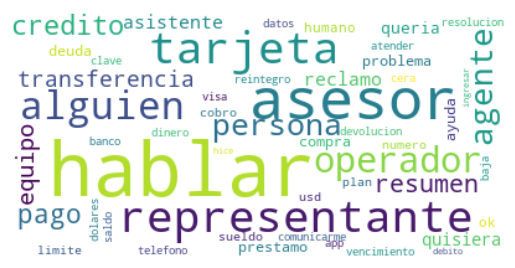

In [27]:
nube_palabras(df_bot_user_nube)